In [1]:
#Load UNSW_NB15
import pandas as pd

train_path = "../data/raw/UNSW_NB15/UNSW_NB15_testing-set.parquet"
test_path  = "../data/raw/UNSW_NB15/UNSW_NB15_training-set.parquet"

In [2]:
df_train = pd.read_parquet(train_path)
df_test  = pd.read_parquet(test_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (82332, 36)
Test shape: (175341, 36)


,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sload,...,trans_depth,response_body_len,ct_src_dport_ltm,ct_dst_sport_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,is_sm_ips_ports,attack_cat,label
0,0.000011,udp,-,INT,2,0,496,0,90909.09375,180363632.0,...,0,0,1,1,0,0,0,0,Normal,0
1,0.000008,udp,-,INT,2,0,1762,0,125000.00000,881000000.0,...,0,0,1,1,0,0,0,0,Normal,0
2,0.000005,udp,-,INT,2,0,1068,0,200000.00000,854400000.0,...,0,0,1,1,0,0,0,0,Normal,0
3,0.000006,udp,-,INT,2,0,900,0,166666.65625,600000000.0,...,0,0,2,1,0,0,0,0,Normal,0
4,0.000010,udp,-,INT,2,0,2126,0,100000.00000,850400000.0,...,0,0,2,1,0,0,0,0,Normal,0


In [3]:
#Identify Target Columns
print(df_train.columns)

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports',
       'attack_cat', 'label'],
      dtype='object')


In [4]:
df_train["label"].value_counts()

label
1    45332
0    37000
Name: count, dtype: int64

In [5]:
#Seperate Features and Target
X_train = df_train.drop(["label", "attack_cat"], axis=1)
y_train = df_train["label"]

X_test = df_test.drop(["label", "attack_cat"], axis=1)
y_test = df_test["label"]

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns
numeric_cols = X_train.select_dtypes(exclude=['object', 'category']).columns

print("Categorical:", categorical_cols)
print("Numeric:", numeric_cols)

Categorical: Index(['proto', 'service', 'state'], dtype='object')
Numeric: Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload',
       'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb',
       'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean',
       'trans_depth', 'response_body_len', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'is_sm_ips_ports'],
      dtype='object')


In [7]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    ))
])

In [9]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [10]:
from sklearn.metrics import classification_report, accuracy_score

y_pred = model.predict(X_test)

print("Train Accuracy:", model.score(X_train, y_train))
print("Test Accuracy:", model.score(X_test, y_test))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Train Accuracy: 0.9952509352378176
Test Accuracy: 0.9113156649043863

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87     56000
           1       0.98      0.89      0.93    119341

    accuracy                           0.91    175341
   macro avg       0.89      0.92      0.90    175341
weighted avg       0.92      0.91      0.91    175341



In [11]:
print(X_train.columns)

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sload', 'dload', 'sloss', 'dloss', 'sinpkt',
       'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt',
       'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'is_sm_ips_ports'],
      dtype='object')


In [12]:
import joblib
joblib.dump(model, "../models/unsw_rf_model.pkl")
print("Model saved successfully.")

Model saved successfully.


In [13]:
print(dir())

['ColumnTransformer', 'In', 'OneHotEncoder', 'Out', 'Pipeline', 'RandomForestClassifier', 'StandardScaler', 'X_test', 'X_train', '_', '_2', '_4', '_9', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__session__', '__spec__', '_dh', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i2', '_i3', '_i4', '_i5', '_i6', '_i7', '_i8', '_i9', '_ih', '_ii', '_iii', '_oh', 'accuracy_score', 'categorical_cols', 'classification_report', 'df_test', 'df_train', 'exit', 'get_ipython', 'joblib', 'model', 'numeric_cols', 'open', 'pd', 'preprocessor', 'quit', 'test_path', 'train_path', 'y_pred', 'y_test', 'y_train']


In [14]:
import shap
import numpy as np

In [15]:
print(model.named_steps)

{'preprocessor': ColumnTransformer(transformers=[('num', StandardScaler(),
                                 Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sload', 'dload',
       'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb',
       'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean', 'dmean',
       'trans_depth', 'response_body_len', 'ct_src_dport_ltm',
       'ct_dst_sport_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'is_sm_ips_ports'],
      dtype='object')),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 Index(['proto', 'service', 'state'], dtype='object'))]), 'classifier': RandomForestClassifier(n_jobs=-1, random_state=42)}


In [16]:
rf_model = model.named_steps["classifier"]
preprocessor = model.named_steps["preprocessor"]

In [17]:
#Transform data
X_train_processed = preprocessor.transform(X_train)
X_test_processed  = preprocessor.transform(X_test)

print("Transformation complete")


Transformation complete


In [18]:
import numpy as np

X_train_transformed = preprocessor.transform(X_train)

# Convert to numpy array if sparse
if hasattr(X_train_transformed, "toarray"):
    X_train_transformed = X_train_transformed.toarray()

# Force numeric dtype
X_train_transformed = X_train_transformed.astype(np.float32)

X_sample = X_train_transformed[:500] 

In [19]:
#create SHAP Explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_sample)

In [21]:
print("X_sample shape:", X_sample.shape)
print("SHAP shape:", np.array(shap_values).shape)

X_sample shape: (500, 182)
SHAP shape: (500, 182, 2)


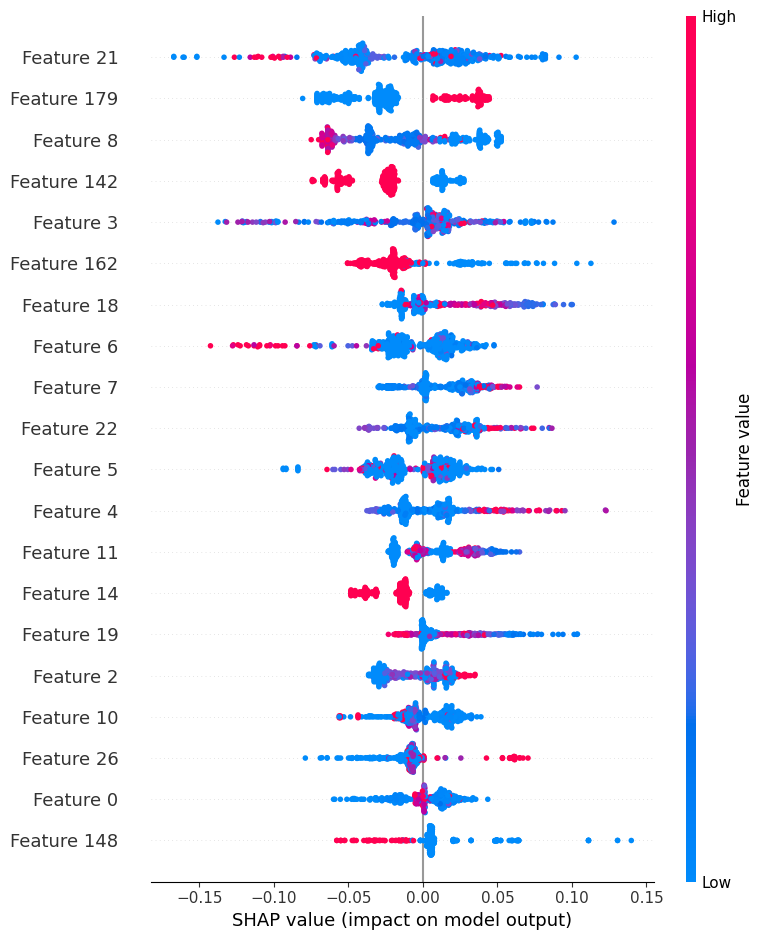

In [22]:
shap.summary_plot(shap_values[:, :, 1], X_sample)

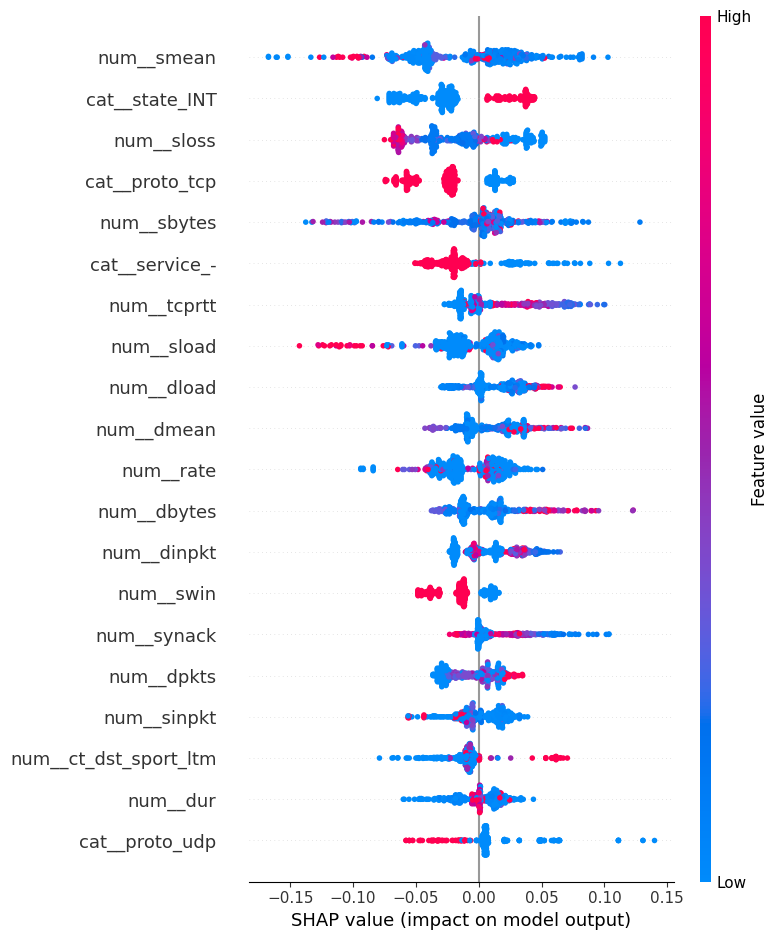

In [24]:
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(
    shap_values[:, :, 1],
    X_sample,
    feature_names=feature_names
)


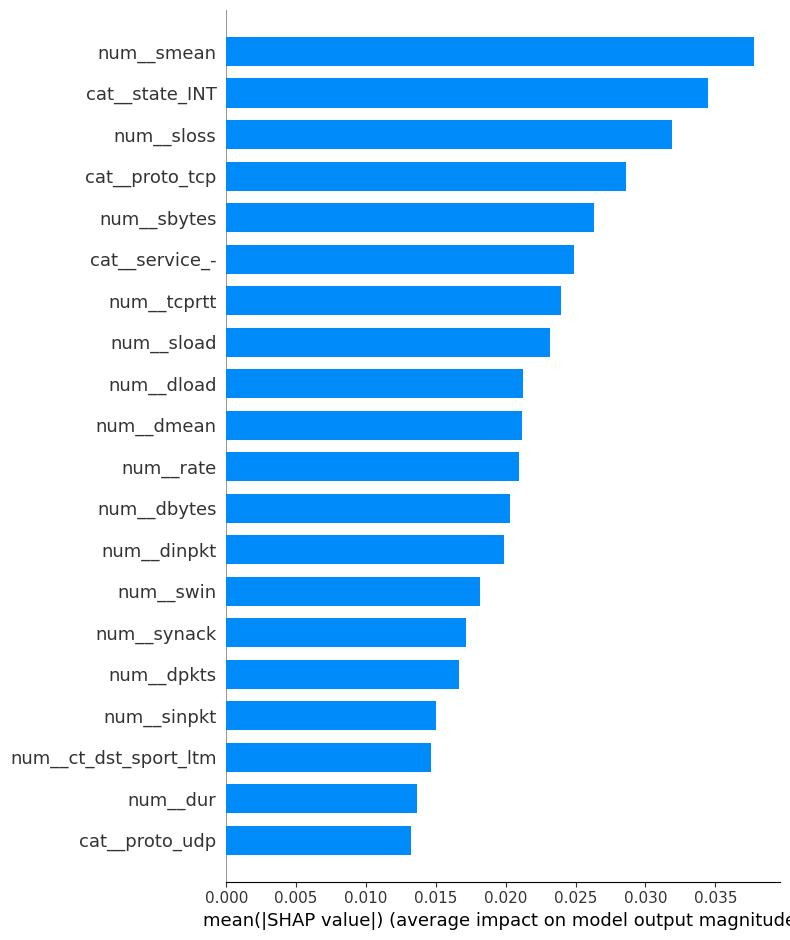

In [25]:
shap.summary_plot(
    shap_values[:, :, 1],
    X_sample,
    feature_names=feature_names,
    plot_type="bar"
)


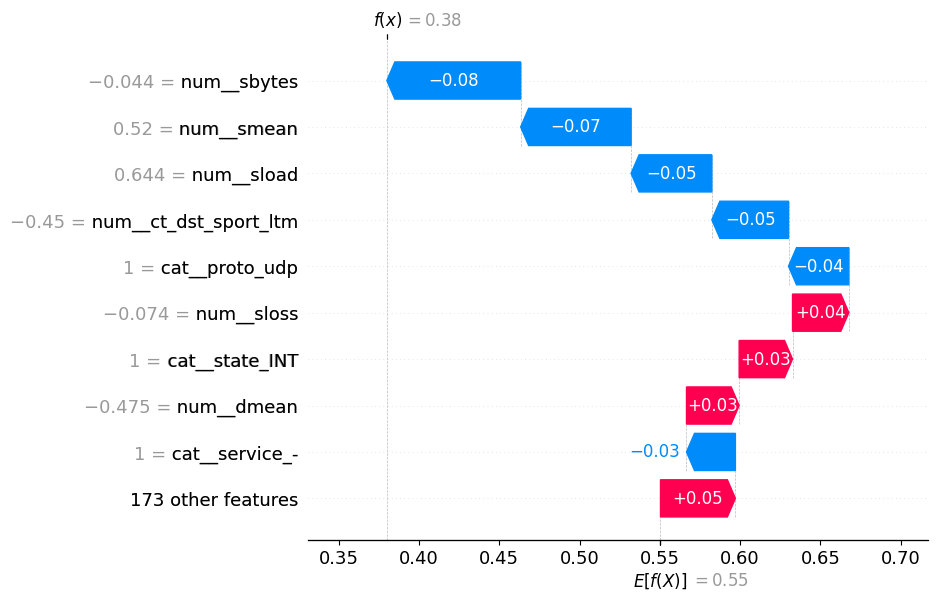

In [26]:
shap.plots.waterfall(
    shap.Explanation(
        values=shap_values[0, :, 1],
        base_values=explainer.expected_value[1],
        data=X_sample[0],
        feature_names=feature_names
    )
)


In [27]:
# Train model
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Probability predictions (important for ROC)
y_prob = model.predict_proba(X_test)[:, 1]


In [28]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_prob))

Accuracy: 0.9113156649043863

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.96      0.87     56000
           1       0.98      0.89      0.93    119341

    accuracy                           0.91    175341
   macro avg       0.89      0.92      0.90    175341
weighted avg       0.92      0.91      0.91    175341


Confusion Matrix:
 [[ 53719   2281]
 [ 13269 106072]]

ROC-AUC Score: 0.9825472248191556


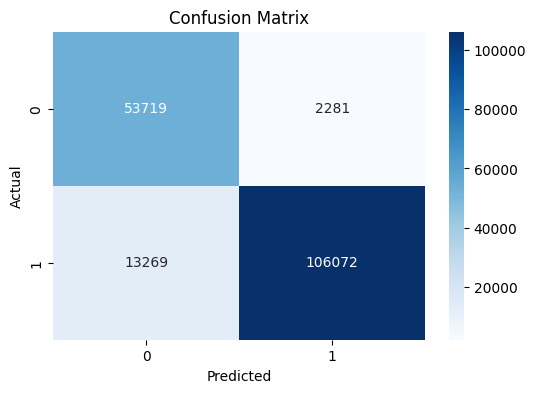

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

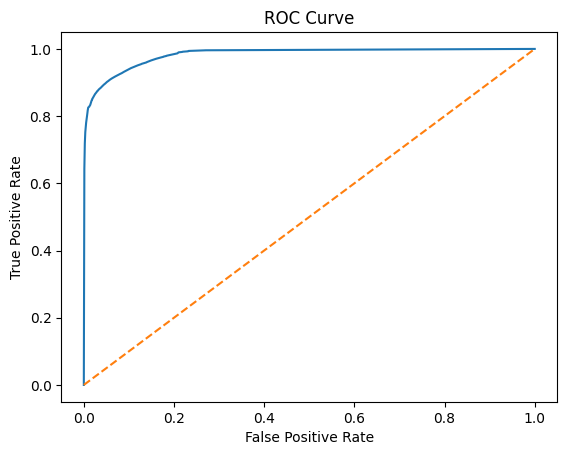

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [31]:
y_prob = model.predict_proba(X_test)[:, 1]

# Example lower threshold
y_pred_custom = (y_prob > 0.4).astype(int)

In [32]:
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

In [33]:
import joblib
joblib.dump(model, "../models/unsw_rf_model.pkl")
print("Model saved successfully.")

Model saved successfully.
